# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

## Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
repo_path = !pwd  # repo path
# env_path  = repo_path[0] + '/env/Reacher_Linux_parallel/Reacher.x86_64'
env_path  = repo_path[0] + '/env/Reacher_Linux_parallel/Reacher.x86_64'
env = UnityEnvironment(file_name= env_path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## Hyperparameters

In [5]:
import numpy as np
import random
import copy
from collections import namedtuple, deque
import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE  = int(1e6)  # replay buffer size
BATCH_SIZE   = 128       # minibatch size
GAMMA        = 0.99      # discount factor
TAU          = 1e-3      # for soft update of target parameters
LR_ACTOR     = 1e-4      # learning rate of the actor 
LR_CRITIC    = 1e-4      # learning rate of the critic
WEIGHT_DECAY = 0         # L2 weight decay

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

cpu


## Agent Class and Methods
The main agent class that is interacted with during the training or scoring.

In [6]:
import numpy as np
import random
import copy
from collections import namedtuple, deque
import torch
import torch.nn.functional as F
import torch.optim as optim


class Agent():
    """Interacts with and learns from the environment.
       inputs:
       state_size:   number of agent(s)'s possible states
       action_size:  number of agent(s)'s possible actions
    """
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.copy_network_parms(self.actor_local, self.actor_target)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.copy_network_parms(self.critic_local, self.critic_target)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn.
           Handles multi-agent environments. 
        """
        
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 1)
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)
        self.noise.reset()

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def copy_network_parms(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(local_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.1):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

## Replay Memory Class and Methods
Replay memory implementation with minimal change to the original Q-learning example that is provided in the class.

In [7]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Define the Actor/Critic nn models(pytorch)

In [8]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed=0, fc1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        x = F.relu(self.fc1(state))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed=0, fcs1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        xs = F.relu(self.fcs1(state))
        xs = self.bn1(xs)
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Main Trainer Class
The main driver class that is used for training and scoring (playing) and serialization.

In [9]:
class ddpg_cont_ctrl:
    def __init__(self, env, state_size, action_size, score_mode=False, seed_in=0):
        self.env   = env
        self.agent = Agent(state_size=state_size, action_size=action_size, random_seed=seed_in)
        self.dump_freq   = 10
        self.score_mode  = score_mode
        self.saved_model_actor  = 'checkpoint_actor.pth'
        self.saved_model_critic = 'checkpoint_critic.pth'
        if score_mode:
            self.agent.actor_local.load_state_dict(torch.load(self.saved_model_actor))
            self.agent.critic_local.load_state_dict(torch.load(self.saved_model_critic))
            print('Model Loaded.')

    def train(self, n_episodes=1000, n_actions=2000, target_score=30.0):
        scores_deque = deque(maxlen=self.dump_freq)
        scores_global = []
       
        for i_episode in range(1, n_episodes + 1):           
            env_info = self.env.reset(train_mode=True)[brain_name]
            num_agents = len(env_info.agents)
            scores = np.zeros(num_agents)
            states = env_info.vector_observations
            self.agent.reset()

            for t in range(n_actions):
                actions = self.agent.act(states)
                env_info = self.env.step(actions)[brain_name]  # step the env
                next_states = env_info.vector_observations     # get the next states (multiple agents allowed)
                rewards = env_info.rewards                     # collect the rewards (multiple agents allowed)
                dones = env_info.local_done                    # check if episode finished
                self.agent.step(states, actions, rewards, next_states, dones)
                states = next_states
                scores += rewards
                if np.any(dones):
                    break
            score = np.mean(scores)
            scores_deque.append(score)         # append most recent score
            avg_score = np.mean(scores_deque)
            scores_global.append(scores)       # save most recent score

            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score), end="")
            if avg_score>target_score:
                if i_episode>100:
                    print('\nReached target score {} in {} episodes.'.format(target_score, i_episode))
                    self.save()
                    break
            if i_episode % self.dump_freq == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score))
                self.save()

        return scores_global

    def play(self, n_episodes=3, n_actions=200, load=False):
            if load:
                self.agent.actor_local.load_state_dict(torch.load(self.saved_model_actor))
                self.agent.critic_local.load_state_dict(torch.load(self.saved_model_critic))

            brain_name = self.env.brain_names[0]
            total_rewards = 0
            
            for i in range(n_episodes):
                env_info   = self.env.reset(train_mode=False)[brain_name]
                states     = env_info.vector_observations
                num_agents = len(env_info.agents)
                scores = np.zeros(num_agents)
                
                for j in range(n_actions):
                    actions = self.agent.act(states)
                    env_info = self.env.step(actions)[brain_name]  # step the env
                    next_states = env_info.vector_observations     # get the next states (multiple agents allowed)
                    rewards = env_info.rewards                     # collect the rewards (multiple agents allowed)
                    dones = env_info.local_done                    # check if episode finished
                    self.agent.step(states, actions, rewards, next_states, dones)
                    states = next_states
                    
                    scores += rewards
                    score   = np.mean(scores)
                    if np.any(rewards):
                        print('\rReward in this episode: {:.2f}\t|\tAccumulated reward of \x1b[5;37;40m {:.2f} \x1b[0m in \x1b[5;37;40m {} \x1b[0m episodes'.format(score, total_rewards/(i+1), i+1), end="")
                    if np.any(dones):
                        total_rewards += score
                        print('\rReward in this episode: {:.2f}\t|\tAccumulated reward of \x1b[5;37;40m {:.2f} \x1b[0m in \x1b[5;37;40m {} \x1b[0m episodes'.format(score, total_rewards/(i+1), i+1), end="")
                        break
    def save(self):
        torch.save(self.agent.actor_local.state_dict(),  'checkpoint_actor.pth')
        torch.save(self.agent.critic_local.state_dict(), 'checkpoint_critic.pth')


## Train and Serialize the Trained Actor/Critic Networks

In [11]:
arm_driver = ddpg_cont_ctrl(env, state_size=state_size, action_size=action_size, score_mode=False, seed_in=12345)
scores     = arm_driver.train(n_episodes=1000, n_actions=2000, target_score=30.0)
np.save('scores.npy', scores)

Episode 10	Average Score: 0.80
Episode 20	Average Score: 1.56
Episode 30	Average Score: 3.04
Episode 40	Average Score: 6.04
Episode 50	Average Score: 9.18
Episode 60	Average Score: 14.95
Episode 70	Average Score: 26.98
Episode 80	Average Score: 35.18
Episode 90	Average Score: 37.38
Episode 100	Average Score: 39.08
Episode 101	Average Score: 39.18
Reached target score 30.0 in 101 episodes.


## Training performance
Visualizing the training progress and superimposing a moving average.

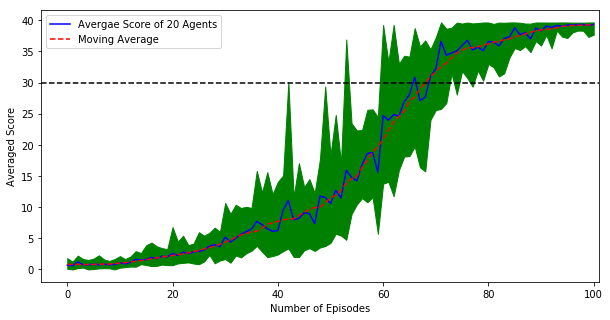

In [16]:
import matplotlib.pyplot as plt
np.random.seed(16)
from scipy.ndimage.filters import uniform_filter1d

n = len(scores)
mean_scores  = [np.mean(scores[i]) for i in np.arange(n)]
lower_limit  = [np.min(scores[i]) for i in np.arange(n)]
upper_limit  = [np.max(scores[i]) for i in np.arange(n)]

# Draw the line plot
plt.figure(figsize=(10,5))
plt.plot(np.arange(n), mean_scores, color='b')
plt.fill_between(np.arange(n), lower_limit, upper_limit, color='g')

# Draw the moving average
win_len = int(n/10)
mv_avg = uniform_filter1d(mean_scores, size=win_len)
plt.plot(mv_avg,'-r',linestyle='--');
plt.axhline(y=30, color='k', linestyle='dashed')
plt.legend(["Avergae Score of 20 Agents", "Moving Average"])

# Define the label of the plots
plt.xlabel('Number of Episodes')
plt.ylabel('Averaged Score')
plt.xlim(right=n)

     
# Display the plot
plt.show()

## Watch the agent play and evaluate its performance

In [10]:
arm_driver = ddpg_cont_ctrl(env, state_size=state_size, action_size=action_size, score_mode=True, seed_in=12345)
env.train_mode = False
scores = arm_driver.play(n_episodes=100,n_actions=2000, load=True)

Model Loaded.
Reward in this episode: 35.02	|	Accumulated reward of  34.41  in  100  episodes

In [11]:
env.close()